In [1]:
'''
!conda list
!pip install opencv-python matplotlib
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!pip3 install torch torchvision torchaudio
'''

"\n!conda list\n!pip install opencv-python matplotlib\n!pip install 'git+https://github.com/facebookresearch/segment-anything.git'\n!pip3 install torch torchvision torchaudio\n"

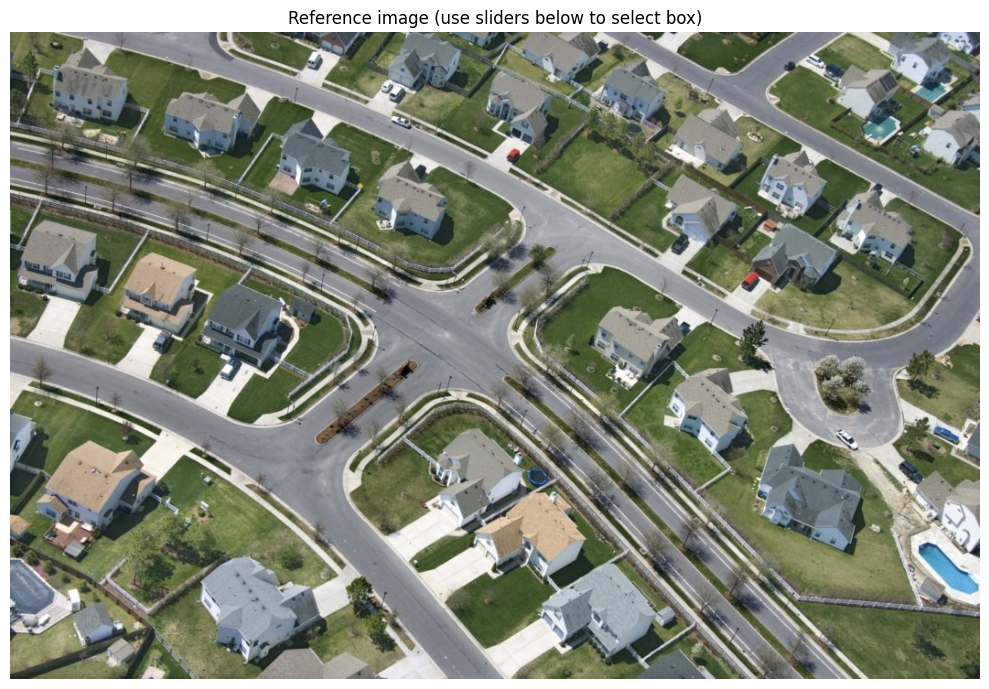

Output()

In [7]:
# First, make sure you have ipywidgets installed
# !pip install ipywidgets

import ipywidgets as widgets
from IPython.display import display, clear_output

# Initialize the SAM predictor
predictor = SamPredictor(sam)

def run_box_segmentation(x1, y1, x2, y2, image):
    """
    Run SAM segmentation with a box defined by two points
    """
    # Ensure coordinates are within image bounds
    height, width = image.shape[:2]
    x1, x2 = max(0, min(x1, width)), max(0, min(x2, width))
    y1, y2 = max(0, min(y1, height)), max(0, min(y2, height))
    
    # Make sure x1 < x2 and y1 < y2
    if x1 > x2:
        x1, x2 = x2, x1
    if y1 > y2:
        y1, y2 = y2, y1
    
    # Set the image for the predictor
    predictor.set_image(image)
    
    # Convert to the format expected by SAM (xyxy)
    input_box = np.array([x1, y1, x2, y2])
    
    # Generate masks
    masks, scores, logits = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],  # Add batch dimension
        multimask_output=True,
    )
    
    # Display the results
    fig, axs = plt.subplots(1, len(masks) + 1, figsize=(15, 10))
    
    # Show original image with box
    axs[0].imshow(image)
    axs[0].plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'r-')
    axs[0].set_title("Original Image with Box")
    axs[0].axis('off')
    
    # Show each predicted mask
    for i, (mask, score) in enumerate(zip(masks, scores)):
        axs[i+1].imshow(image)
        # Show mask
        color = np.array([30/255, 144/255, 255/255, 0.6])
        mask_image = mask.reshape(mask.shape[0], mask.shape[1], 1) * color.reshape(1, 1, -1)
        axs[i+1].imshow(mask_image)
        axs[i+1].set_title(f"Mask {i+1}, Score: {score:.3f}")
        axs[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return masks, scores

def interactive_segmentation_widgets(image):
    """
    Create interactive widgets for selecting box coordinates
    """
    height, width = image.shape[:2]
    
    # Create a figure to display the image
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    ax.set_title("Reference image (use sliders below to select box)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Create sliders for the coordinates
    x1_slider = widgets.IntSlider(
        value=width//4, min=0, max=width-1, 
        description='X1:', continuous_update=False
    )
    y1_slider = widgets.IntSlider(
        value=height//4, min=0, max=height-1, 
        description='Y1:', continuous_update=False
    )
    x2_slider = widgets.IntSlider(
        value=3*width//4, min=0, max=width-1, 
        description='X2:', continuous_update=False
    )
    y2_slider = widgets.IntSlider(
        value=3*height//4, min=0, max=height-1, 
        description='Y2:', continuous_update=False
    )
    
    # Create a button to trigger segmentation
    segment_button = widgets.Button(description="Run Segmentation")
    output = widgets.Output()
    
    # Define button click behavior
    def on_button_clicked(b):
        with output:
            clear_output()
            masks, scores = run_box_segmentation(
                x1_slider.value, y1_slider.value, 
                x2_slider.value, y2_slider.value,
                image
            )
            
    segment_button.on_click(on_button_clicked)
    
    # Show preview of the box when sliders change
    def update_preview(*args):
        # Create a new figure to show the preview
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(image)
        ax.set_title("Box Preview")
        
        # Draw the box
        x1, y1 = x1_slider.value, y1_slider.value
        x2, y2 = x2_slider.value, y2_slider.value
        ax.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'r-', linewidth=2)
        
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    preview_button = widgets.Button(description="Preview Box")
    preview_button.on_click(update_preview)
    
    # Display all widgets
    display(widgets.HBox([x1_slider, y1_slider]))
    display(widgets.HBox([x2_slider, y2_slider]))
    display(widgets.HBox([preview_button, segment_button]))
    display(output)

# Call this function with your image
interactive_segmentation_widgets(image)